In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj
import sys
from joblib import Parallel, delayed
from tqdm import tqdm

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm import Boxm

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 260.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-11-10 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (37.5, -97.5, 6500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 0,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5),  # integration time step
    "max_age": pd.Timedelta(hours=2),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 50.0,  # initial plume width, [m]
    "shear": 0.005,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-11-10 12:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=30),  # chemistry runtime
    "ts_chem": pd.Timedelta(seconds=20),  # chemistry time step
    "lat_bounds": (37.0, 38.0),  # lat bounds [deg]
    "lon_bounds": (-98.0, -97.0),  # lon bounds [deg]
    "alt_bounds": (6000, 7000),  # alt bounds [m]
    "hres_chem": 0.5,  # horizontal resolution [deg]
    "vres_chem": 500,  # vertical resolution [m]
}

In [6]:
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1] + chem_params["vres_chem"], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars,
    coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times},
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 169MB
Dimensions:                              (longitude: 3, latitude: 3, level: 3,
                                          time: 129601)
Coordinates:
  * longitude                            (longitude) float64 24B -98.0 ... -97.0
  * latitude                             (latitude) float64 24B 37.0 37.5 38.0
  * level                                (level) float64 24B 410.6 440.3 471.8
  * time                                 (time) datetime64[ns] 1MB 2022-11-10...
    air_pressure                         (level) float64 24B 4.106e+04 ... 4....
    altitude                             (level) float64 24B 7e+03 6.5e+03 6e+03
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 28MB dask.array<chunksize=(3, 3, 3, 100), meta=np.ndarray>

In [8]:
# instantiate FlightGen object
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [9]:
fl = fl_gen.traj_gen()

fl

[Flight [4 keys x 5 length, 3 attributes]
 	Keys: longitude, latitude, altitude, time
 	Attributes:
 	time                [2022-11-10 14:00:00, 2022-11-10 14:08:00]
 	longitude           [-97.5, -97.113]
 	latitude            [37.5, 37.805]
 	altitude            [6500.0, 6500.0]
 	flight_id           0
 	aircraft_type       A320
 	crs                 EPSG:4326]

In [10]:
# estimate fuel burn and emissions using ps_model and emissions model
fl = fl_gen.calc_fb_emissions()

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:128: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i].dataframe[column] = flights[i].dataframe[column].fillna(method='ffill')


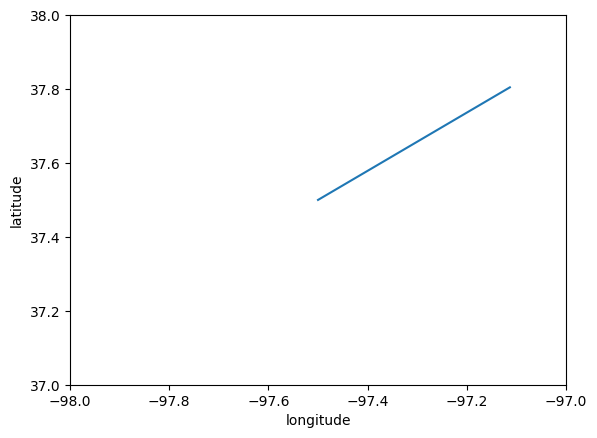

In [11]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for i in fl:
    i.plot(ax=ax)

In [12]:
# simulate plume dispersion/advection using dry advection model
fl_df, pl_df = fl_gen.sim_plumes()

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 30)

fl_df

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i][column] = flights[i][column].fillna(method='ffill')


,longitude,latitude,altitude,time,air_temperature,specific_humidity,true_airspeed,flight_id,aircraft_mass,engine_efficiency,fuel_flow,fuel_burn,thrust,rocd,fuel_flow_per_engine,...,nvpm_number,CO2,H2O,SO2,nvPM,NO,NO2,CO,HCHO,CH3CHO,C2H4,C3H6,C2H2,BENZENE,waypoint
0,-97.500000,37.500000,6500.0,2022-11-10 14:00:00,260.0,0.001,100.143033,0.0,58106.820235,0.185702,0.576599,69.191848,46115.793324,0.0,0.288299,...,5.941944e+16,7.277798e-07,2.832814e-07,1.934605e-10,6.353203e-12,2.059706e-09,1.084056e-10,7.868643e-11,9.212070e-13,3.070690e-13,1.151509e-12,3.070690e-13,3.070690e-13,1.535345e-13,0
1,-97.403300,37.576153,6500.0,2022-11-10 14:02:00,260.0,0.001,100.091513,0.0,58037.628387,0.185627,0.575783,69.093947,46055.573151,0.0,0.287891,...,5.925324e+16,7.271242e-07,2.830262e-07,1.932862e-10,6.333891e-12,2.056033e-09,1.082123e-10,7.861555e-11,9.203771e-13,3.067924e-13,1.150471e-12,3.067924e-13,3.067924e-13,1.533962e-13,1
2,-97.306599,37.652307,6500.0,2022-11-10 14:04:00,260.0,0.001,100.039930,0.0,57968.534440,0.185552,0.574969,68.996305,45995.534018,0.0,0.287485,...,5.908768e+16,7.264710e-07,2.827719e-07,1.931125e-10,6.314656e-12,2.052373e-09,1.080196e-10,7.854493e-11,9.195503e-13,3.065168e-13,1.149438e-12,3.065168e-13,3.065168e-13,1.532584e-13,2
3,-97.209899,37.728460,6500.0,2022-11-10 14:06:00,260.0,0.001,99.988285,0.0,57899.538135,0.185489,0.574432,68.931797,45960.641005,0.0,0.287216,...,5.897921e+16,7.261667e-07,2.826535e-07,1.930316e-10,6.303196e-12,2.050307e-09,1.079109e-10,7.851202e-11,9.191651e-13,3.063884e-13,1.148956e-12,3.063884e-13,3.063884e-13,1.531942e-13,3
4,-97.113198,37.804613,6500.0,2022-11-10 14:08:00,260.0,0.001,99.988285,0.0,57830.606338,0.185489,0.574432,68.931797,45960.641005,0.0,0.287216,...,5.897921e+16,7.261667e-07,2.826535e-07,1.930316e-10,6.303196e-12,2.050307e-09,1.079109e-10,7.851202e-11,9.191651e-13,3.063884e-13,1.148956e-12,3.063884e-13,3.063884e-13,1.531942e-13,4


In [13]:
# fl_gen.anim_fl(fl_df, pl_df)

In [14]:
# convert plume dataframe to EMI geospatial xarray dataset
emi = fl_gen.plume_to_grid(lats, lons, alts, times)

In [15]:
# init boxm simulation and generate chemistry dataset
boxm = Boxm(met=met, params=chem_params)

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [16]:
# run boxm simulation
chem = boxm.eval(emi)

/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["ZEN_orig"] = (["time"], da.zeros((self.boxm_ds.dims["time"])))
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm.py:169: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["J"] = (["time", "level", "longitude", "latitude", "photol_params"], da.zeros((self.boxm_ds.dims["time"], self.boxm_ds.dims["level"], self.boxm_ds.dims["longitude"], self.boxm_ds.dims["latitude"], 5)))
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm.py:170: Fu

<xarray.Dataset> Size: 7GB
Dimensions:          (time: 129601, cell: 27, species: 219, emi_species: 9,
                      photol_params: 5, photol_coeffs: 5, therm_coeffs: 5)
Coordinates:
  * time             (time) datetime64[ns] 1MB 2022-11-10T12:00:00 ... 2022-1...
    air_pressure     (cell) float64 216B dask.array<chunksize=(27,), meta=np.ndarray>
    altitude         (cell) float64 216B dask.array<chunksize=(27,), meta=np.ndarray>
  * species          (species) <U10 9kB 'O1D' 'O' 'OH' ... 'EMPOA' 'P2007'
  * emi_species      (emi_species) <U7 252B 'NO' 'NO2' 'CO' ... 'C2H2' 'BENZENE'
    level            (cell) float64 216B 410.6 410.6 410.6 ... 471.8 471.8 471.8
    longitude        (cell) float64 216B -98.0 -98.0 -98.0 ... -97.0 -97.0 -97.0
    latitude         (cell) float64 216B 37.0 37.5 38.0 37.0 ... 37.0 37.5 38.0
Dimensions without coordinates: cell, photol_params, photol_coeffs, therm_coeffs
Data variables: (12/17)
    air_temperature  (time, cell) float64 28MB dask.a

In [17]:
# plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# print(boxm.boxm_ds["sza"].sel(cell=0).values[500])
# print(boxm.boxm_ds["ZEN_orig"].values[500])

# boxm.boxm_ds["sza"].sel(cell=0).plot()
# boxm.boxm_ds["ZEN_orig"].plot()
# plt.legend()
# plt.show()

In [18]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

#boxm.boxm_ds["Y"].sel(species="NO", cell=13).plot()
# boxm.boxm_ds["Y_orig"].sel(species="O3").plot()
# plt.legend()
# plt.show()

boxm.boxm_ds["species"].values


array(['O1D', 'O', 'OH', 'NO2', 'NO3', 'O3', 'N2O5', 'NO', 'HO2', 'H2',
       'CO', 'H2O2', 'HONO', 'HNO3', 'HO2NO2', 'SO2', 'SO3', 'HSO3', 'NA',
       'SA', 'CH4', 'CH3O2', 'C2H6', 'C2H5O2', 'C3H8', 'IC3H7O2',
       'RN10O2', 'NC4H10', 'RN13O2', 'C2H4', 'HOCH2CH2O2', 'C3H6',
       'RN902', 'TBUT2ENE', 'RN12O2', 'NRN6O2', 'NRN9O2', 'NRN12O2',
       'HCHO', 'HCOOH', 'CH3CO2H', 'CH3CHO', 'C5H8', 'RU14O2', 'NRU14O2',
       'UCARB10', 'APINENE', 'RTN28O2', 'NRTN28O2', 'RTN26O2', 'TNCARB26',
       'RCOOH25', 'BPINENE', 'RTX28O2', 'NRTX28O2', 'RTX24O2', 'TXCARB24',
       'TXCARB22', 'C2H2', 'CARB3', 'BENZENE', 'RA13O2', 'AROH14',
       'TOLUENE', 'RA16O2', 'AROH17', 'OXYL', 'RA19AO2', 'RA19CO2',
       'CH3CO3', 'C2H5CHO', 'C2H5CO3', 'CH3COCH3', 'RN8O2', 'RN11O2',
       'CH3OH', 'C2H5OH', 'NPROPOL', 'IPROPOL', 'CH3CL', 'CH2CL2',
       'CHCL3', 'CH3CCL3', 'TCE', 'TRICLETH', 'CDICLETH', 'TDICLETH',
       'CARB11A', 'RN16O2', 'RN15AO2', 'RN19O2', 'RN18AO2', 'RN13AO2',
       'RN16AO

<Figure size 1000x600 with 0 Axes>

In [19]:
# Resample and calculate the mean along the time dimension for each species
ds_hourly = boxm.boxm_ds["Y"].sel(cell=13).resample(time="1h").mean(dim="time")
ds_hourly_orig = boxm.boxm_ds["Y_orig"].resample(time="1h").mean(dim="time")

# Calculate the mean for each species along the time dimension
ds_hourly_mean = ds_hourly.mean(dim="time")
ds_hourly_orig_mean = ds_hourly_orig.mean(dim="time")

# Calculate the numerator and denominator for the correlation coefficient for each species
numerator = np.sum((ds_hourly - ds_hourly_mean) * (ds_hourly_orig - ds_hourly_orig_mean), axis=0)
denominator = np.sqrt(np.sum((ds_hourly - ds_hourly_mean) ** 2, axis=0) * np.sum((ds_hourly_orig - ds_hourly_orig_mean) ** 2, axis=0))

# Calculate the correlation coefficient and R² for each species
correlation_coefficient = numerator / denominator
r_squared = correlation_coefficient ** 2

# Calculate RMSE for each species
rmse = np.sqrt(np.mean((ds_hourly - ds_hourly_orig) ** 2, axis=0))

# Calculate the range of the original data for each species
range_orig = ds_hourly_orig.max(dim="time") - ds_hourly_orig.min(dim="time")

# Calculate NRMSE for each species
nrmse = rmse / range_orig * 100

# Print R² and NRMSE for each species
for s, species in enumerate(boxm.boxm_ds["species"].values):
    print(f"R² for {species} is {r_squared[s]}")
    print(f"NRMSE for {species} is {nrmse[s]}")

# Convert the r_squared and nrmse arrays to a pandas DataFrame
results_df = pd.DataFrame({
    "r_squared": r_squared,
    "nrmse": nrmse
}, index=boxm.boxm_ds["species"].values)

# Send to CSV
results_df.to_csv("/home/ktait98/pycontrails_kt/pycontrails/models/files/validation/r_squared_nrmse_US.csv")

R² for O1D is <xarray.DataArray ()> Size: 8B
array(0.99999308)
Coordinates:
    air_pressure  float64 8B 4.403e+04
    altitude      float64 8B 6.5e+03
    species       <U10 40B 'O1D'
    level         float64 8B 440.3
    longitude     float64 8B -97.5
    latitude      float64 8B 37.5
NRMSE for O1D is <xarray.DataArray ()> Size: 8B
array(0.06933906)
Coordinates:
    air_pressure  float64 8B ...
    altitude      float64 8B ...
    species       <U10 40B 'O1D'
    level         float64 8B ...
    longitude     float64 8B ...
    latitude      float64 8B ...
R² for O is <xarray.DataArray ()> Size: 8B
array(0.99999483)
Coordinates:
    air_pressure  float64 8B 4.403e+04
    altitude      float64 8B 6.5e+03
    species       <U10 40B 'O'
    level         float64 8B 440.3
    longitude     float64 8B -97.5
    latitude      float64 8B 37.5
NRMSE for O is <xarray.DataArray ()> Size: 8B
array(0.08757982)
Coordinates:
    air_pressure  float64 8B ...
    altitude      float64 8B ...
    sp

: 